## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **2. Import the necessary libraries**
---

In [2]:
import h5py
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model


print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.2.0
numpy:       1.18.4
matplotlib:  3.2.1
sklearn:     0.22.2.post1


## **3. Set matplotlib to have seaborn plot style**
---

In [3]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **4. Load ECG data**
---
* Step 1: Load the h5py file and extract the values
* Step 2: Convert the data and label into numpy arrays
* Step 3: Tranpose the data and label
* Step 4: Make separate arrays for Normal and CAD ECG signals
* Step 5: Inspect the shape and data type of the 'nor' and 'cad' arrays

In [4]:
f        = h5py.File('/content/gdrive/My Drive/iss/prumls/data/cad5sec.mat','r')# Step 1
X        = f["data"]
Y        = f["classLabel"]

                                                                                # Step 2
data     = np.array(X)                                                          
label    = np.array(Y)

                                                                                # Step 3
data     = np.transpose(data)                                                   
label    = np.transpose(label)

                                                                                # Step 4
nor      = data[0:32000]
cad      = data[32000:38120]

                                                                                # Step 5
print('The shape of nor is', nor.shape, 'and the data type is', nor.dtype)
print('The shape of cad is', cad.shape, 'and the data type is', cad.dtype)

The shape of nor is (32000, 1285) and the data type is float64
The shape of cad is (6120, 1285) and the data type is float64


## **6. Create makeSteps function**
---

In [5]:
def makeSteps(dat, length, dist):
    width           = dat.shape[1]
    numOfSteps      = int(np.floor((width-length)/dist)+1)
    
                                        # Initialize the output
    segments        = np.zeros([dat.shape[0],numOfSteps,length],
                               dtype=dat.dtype)
    
    for l in range(numOfSteps):
        segments[:,l,:]     = dat[:,(l*dist):(l*dist+length)]
        
    return segments

print(makeSteps)

<function makeSteps at 0x7fddaec37378>


## **7. Prepare data for training and testing**
---
* Step 1: Split the dataset into training and testing
* Step 2: Generate segments for each signal
* Step 3: Consolidate the arrays
* Step 4: Inspect the data shape and type

In [6]:
                                                                                # Step 1
trNor        = nor[0:28800].copy()
tsNor        = nor[28800:32000].copy()
trCad        = cad[0:5000].copy()
tsCad        = cad[5000:6120].copy()

                                                                                # Step 2
length       = 24
dist         = 6
trNorS       = makeSteps(trNor, length, dist)
tsNorS       = makeSteps(tsNor, length, dist)
trCadS       = makeSteps(trCad, length, dist)
tsCadS       = makeSteps(tsCad, length, dist)

                                                                                # Step 3
trDat        = np.vstack([trNorS,trCadS])
tsDat        = np.vstack([tsNorS,tsCadS])

trLbl        = np.vstack([np.zeros([trNorS.shape[0],1]),
                          np.ones([trCadS.shape[0],1])])
tsLbl        = np.vstack([np.zeros([tsNorS.shape[0],1]),
                          np.ones([tsCadS.shape[0],1])])

                                                                                # Step 4
print('The shape of trDat is', trDat.shape, "and the type is", trDat.dtype)
print('The shape of trLbl is', trLbl.shape, "and the type is", trLbl.dtype)
print('')
print('The shape of tsDat is', tsDat.shape, "and the type is", tsDat.dtype)
print('The shape of tsLbl is', tsLbl.shape, "and the type is", tsLbl.dtype)

The shape of trDat is (33800, 211, 24) and the type is float64
The shape of trLbl is (33800, 1) and the type is float64

The shape of tsDat is (4320, 211, 24) and the type is float64
The shape of tsLbl is (4320, 1) and the type is float64


## **8. Define the CNN-LSTM model**
___
* Step 1: Set a name for the coming model (required for saving)
* Step 2: Define the CNN-LSTM model
* Step 3: Create models for training and testing
* Step 4: Display the summary of the model of interest 

In [7]:
modelname   = 'wks3_2_2'                                                        # Step 1

                                                                                # Step 2
def createModel():        
    inputs      = Input(shape=(trDat.shape[1],length))
    y           = Conv1D(32, 5, activation='relu')(inputs)
    y           = Dropout(0.25)(y)
    y           = Conv1D(32, 5, activation='relu')(y)
    y           = MaxPooling1D(2)(y)
    y           = Conv1D(48, 5, activation='relu')(y)
    y           = Dropout(0.5)(y)
    y           = Conv1D(48, 5, activation='relu')(y)
    y           = MaxPooling1D(2)(y)
    y           = Conv1D(64, 5, activation='relu')(y)
    y           = Dropout(0.5)(y)
    y           = Conv1D(64, 5, activation='relu')(y)
    y           = MaxPooling1D(2)(y)
    
    y           = LSTM(8, 
                       return_sequences=True, 
                       dropout=0.5, 
                       recurrent_dropout=0.5)(y)
    y           = LSTM(4, 
                       return_sequences=True, 
                       dropout=0.5, 
                       recurrent_dropout=0.5)(y)
    y           = LSTM(2)(y)
    y           = Dense(1, activation='sigmoid')(y)
    
    model       = Model(inputs=inputs,outputs=y)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

                                                                                # Step 3
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()                                                                 # Step 4

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 211, 24)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 207, 32)           3872      
_________________________________________________________________
dropout (Dropout)            (None, 207, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 203, 32)           5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 101, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 48)            7728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 48)            0     

## **9. Create the callbacks to be applied during training**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callback objects into a list

In [8]:
                                                                                # Step 1
folderpath      = '/content/gdrive/My Drive/iss/prumls/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')


Callbacks created:

Path to model: /content/gdrive/My Drive/iss/prumls/colab/wks3_2_2.hdf5
Path to log:   /content/gdrive/My Drive/iss/prumls/colab/wks3_2_2.csv


## **10. Train the deep learning model**
___

In [9]:
model.fit(trDat, 
          trLbl, 
          validation_data=(tsDat, tsLbl), 
          epochs=40, 
          batch_size=128,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/40
265/265 [==============================] - 67s 251ms/step - loss: 0.5735 - accuracy: 0.8502 - val_loss: 0.5733 - val_accuracy: 0.7407
Epoch 2/40
265/265 [==============================] - 66s 249ms/step - loss: 0.4319 - accuracy: 0.8521 - val_loss: 0.5175 - val_accuracy: 0.7407
Epoch 3/40
265/265 [==============================] - 67s 253ms/step - loss: 0.2845 - accuracy: 0.9020 - val_loss: 0.4462 - val_accuracy: 0.8377
Epoch 4/40
265/265 [==============================] - 67s 254ms/step - loss: 0.1717 - accuracy: 0.9681 - val_loss: 0.4366 - val_accuracy: 0.8435
Epoch 5/40
265/265 [==============================] - 68s 257ms/step - loss: 0.1201 - accuracy: 0.9786 - val_loss: 0.4344 - val_accuracy: 0.8648
Epoch 6/40
265/265 [==============================] - 67s 253ms/step - loss: 0.1016 - accuracy: 0.9803 - val_loss: 0.4105 - val_accuracy: 0.8741
Epoch 7/40
265/265 [==============================] - 67s 255ms/step - loss: 0.0853 - accuracy: 0.9833 - val_loss: 0.4206 - val_ac

## **11. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [10]:
                                                                                # Step 1
modelGo.load_weights(filepath)
print("Model weights loaded from:", filepath)

modelGo.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

predicts    = modelGo.predict(tsDat)                                            # Step 2
print("Prediction completes.")

Model weights loaded from: /content/gdrive/My Drive/iss/prumls/colab/wks3_2_2.hdf5
Prediction completes.


## **12. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Calculate the accuracy score
* Step 3: Generate classification report

In [11]:
                                                                                # Step 1
labelname   = ['Normal',          # The label for reporting metrics
               'CAD']
                                                                                
testScores  = metrics.accuracy_score(tsLbl,predicts.round())                    # Step 2
              
                                                                                # Step 3
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(tsLbl,
                                    predicts.round(),
                                    target_names=labelname,
                                    digits=4))



Best accuracy (on testing dataset): 88.33%
              precision    recall  f1-score   support

      Normal     0.8742    0.9841    0.9259      3200
         CAD     0.9290    0.5955    0.7258      1120

    accuracy                         0.8833      4320
   macro avg     0.9016    0.7898    0.8258      4320
weighted avg     0.8884    0.8833    0.8740      4320



## **13. Print confusion matrix**
---

In [12]:
confusion   = metrics.confusion_matrix(tsLbl,predicts.round())    
print(confusion)

[[3149   51]
 [ 453  667]]


## **14. Plot curves on validation loss and accuracy**
---

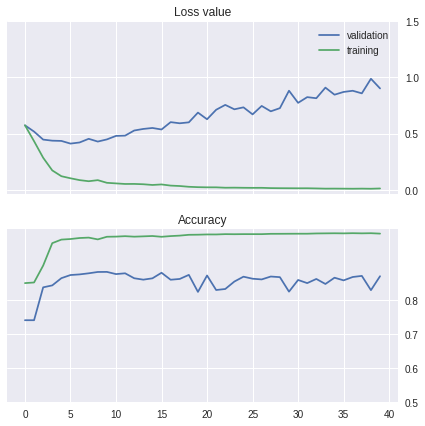

In [13]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **15. Save the model plot**
---

In [14]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/prumls/colab/wks3_2_2_plot.png
